In [1]:
# Base scenario
NUM_SIM = 100
MAX_NUMBER_INVOICES = 500
MIN_PERC_NOT_COLLATERALIZED = 0.05
MAX_PERC_NOT_COLLATERALIZED = 0.5
MIN_INVOICE_REQ_NOT_COL = 100
MAX_INVOICE_REQ_NOT_COL = 2000
PROB_HACK = 0.0
PROB_UNPAID = 0.00 + PROB_HACK
PROB_ADD_LIQUIDITY = 0.0
MIN_LIQUIDITY_ADD = 0
MAX_LIQUIDITY_ADD = 0
MAX_DELAY_INVOICE = 120
MIN_DELAY_INVOICE = 30
MAX_DAYS = 500
ADDITIONAL_DAYS = 30
MAX_DAYS_SIM = MAX_DAYS + MAX_DELAY_INVOICE + ADDITIONAL_DAYS
START_Q_LIQUIDITY = 10000
START_PREM_LIQUIDITY = 0
INITIAL_TOTAL_VOLUME = START_Q_LIQUIDITY + START_PREM_LIQUIDITY

def reset():
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY = MIN_LIQUIDITY_ADD = MAX_LIQUIDITY_ADD = 0
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = 30, 120
    global PROB_UNPAID
    PROB_UNPAID = 0
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL = 100, 2000
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MIN_PERC_NOT_COLLATERALIZED, MAX_PERC_NOT_COLLATERALIZED = 0.05, 0.5

def scenario_1(prob_add_liq, perc_liq_add):
    global PROB_ADD_LIQUIDITY
    global MIN_LIQUIDITY_ADD
    global MAX_LIQUIDITY_ADD
    PROB_ADD_LIQUIDITY, MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD = prob_add_liq, 0, perc_liq_add*START_Q_LIQUIDITY

def scenario_2(prob_unpaid):
    global PROB_UNPAID
    PROB_UNPAID = prob_unpaid

def scenario_3(min_invoice_delay, max_invoice_delay):
    global MIN_DELAY_INVOICE
    global MAX_DELAY_INVOICE
    MIN_DELAY_INVOICE, MAX_DELAY_INVOICE = min_invoice_delay, max_invoice_delay

def scenario_4(invoice_amount_not_col):
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    MIN_INVOICE_REQ_NOT_COL = MAX_INVOICE_REQ_NOT_COL = invoice_amount_not_col*START_Q_LIQUIDITY

def scenario_5(invoice_col):
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col

def hack_scenario(prob_hack, invoice_col):
    global PROB_UNPAID
    global MIN_PERC_NOT_COLLATERALIZED
    global MAX_PERC_NOT_COLLATERALIZED
    global MIN_INVOICE_REQ_NOT_COL
    global MAX_INVOICE_REQ_NOT_COL
    PROB_UNPAID = prob_hack
    MAX_PERC_NOT_COLLATERALIZED = MIN_PERC_NOT_COLLATERALIZED = 1-invoice_col

In [2]:
import random
import sys

def unpaid_delayed_aux(prob_unpaid):
    probability_delayed = random.random() > prob_unpaid
    if probability_delayed:
        return random.randint(MIN_DELAY_INVOICE, MAX_DELAY_INVOICE)
    else:
        return 100000

def generate_invoices():
    invoices_list = []
    for i in range(0, MAX_NUMBER_INVOICES):
        delay_days = unpaid_delayed_aux(PROB_UNPAID)

        invoices_list.append({
            'id':i,
            'q':round(random.uniform(MIN_PERC_NOT_COLLATERALIZED,MAX_PERC_NOT_COLLATERALIZED), 2),
            'q_amount': random.randint(MIN_INVOICE_REQ_NOT_COL, MAX_INVOICE_REQ_NOT_COL),
            'delay_days': delay_days,
            'col_when': 0,
            'collateralized': False,
            'paid': False
        })

    return invoices_list

def modify_liquidity_q(amount, total_q_volume):
    total_q_volume += amount
    return total_q_volume

def modifiy_liquidity_prem(amount, total_premium):
    total_premium += amount
    return total_premium

def get_premium(q_amount, q, total_q_volume, total_premium):
    volume = total_q_volume + total_premium
    prem = round(q*q/(1-q*(1+q_amount/(volume)))*q_amount, 2)
    return prem

def rkAMM():
    invoices =  generate_invoices()
    sum_q_amount = 0
    for i in range(len(invoices)):
        sum_q_amount += list(invoices[i].values())[2]
        #print(invoices[i])
    #print("Total collateral to afford", sum_q_amount)
    
    total_premium = START_PREM_LIQUIDITY
    total_q_volume = START_Q_LIQUIDITY
    total_volume = total_premium + total_q_volume
    paid_counter = 0
    collateralized_counter = 0
    collateralized_amount = 0
    unpayed_amount = 0
    unavailable_days = 0

    array_q_volume = [total_q_volume]
    array_prem = [0]
    array_vol = [total_volume]

    for i in range(0, MAX_DAYS_SIM):
        prob_liq_added = random.random() < PROB_ADD_LIQUIDITY

        if prob_liq_added:
            total_q_volume = modify_liquidity_q(random.randint(MIN_LIQUIDITY_ADD, MAX_LIQUIDITY_ADD), total_q_volume)
            
        try:

            q = invoices[i]['q']
            q_amount = invoices[i]['q_amount']

            if(total_q_volume - invoices[i]['q_amount']  > 0 and i < len(invoices) and invoices[i]['collateralized'] == False):
                prem = get_premium(q_amount, q, total_q_volume, total_premium)
                total_q_volume = modify_liquidity_q(-q_amount, total_q_volume)
                total_premium = modifiy_liquidity_prem(prem, total_premium)
                collateralized_counter += 1
                invoices[i]['collateralized'] = True
                invoices[i]['col_when'] = i

                collateralized_amount += q_amount
                unpayed_amount += q_amount

            else:               
                if(total_q_volume - invoices[i]['q_amount']  < 0):
                    unavailable_days += 1

            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpayed_amount -= j['q_amount']
                
        except:

            for j in invoices:
                if(i - j['col_when'] == j['delay_days'] and j['collateralized'] == True):
                    total_q_volume = modify_liquidity_q(j['q_amount'], total_q_volume)
                    j['paid'] = True
                    paid_counter += 1
                    unpayed_amount -= j['q_amount']

        array_q_volume.append(total_q_volume)
        array_prem.append(total_premium)
        total_volume = total_q_volume + total_premium
        array_vol.append(total_volume)

    return collateralized_counter, (collateralized_counter-paid_counter), unpayed_amount, paid_counter, collateralized_amount, sum_q_amount, total_premium, total_volume, array_q_volume, array_prem, array_vol, unavailable_days

In [3]:
from ntpath import join
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

def result():
    col = []
    imp = []
    total_loss = []
    pag = []
    total_to_col = []
    total_q = []
    total_prem = []
    total_vol = []
    array_q_vol = []
    array_prem = []
    array_vol = []
    un_days = []
    
    for i in range(0, NUM_SIM):    
        results = rkAMM()

        col.append(results[0])
        imp.append(results[1])
        total_loss.append(results[2])
        pag.append(results[3])
        total_to_col.append(results[4])
        total_q.append(results[5])
        total_prem.append(results[6])
        total_vol.append(results[7])
        array_q_vol.append(results[8]) 
        array_prem.append(results[9])
        array_vol.append(results[10])
        un_days.append(results[11])
    
    array_q_vol = [sum(x) for x in zip(*array_q_vol)]
    q_volume_values = [x / NUM_SIM for x in array_q_vol]

    array_prem = [sum(x) for x in zip(*array_prem)]
    prem_values = [x / NUM_SIM for x in array_prem]

    array_vol = [sum(x) for x in zip(*array_vol)]
    volume_values = [x / NUM_SIM for x in array_vol]

    data = [
        ["|", "Number of simulations" , "|", f"{NUM_SIM}", "|"],
        ["|", "Simulation time period" , "|", f"{MAX_DAYS_SIM} days", "|"],
        ["|", "Total of invoices" , "|", f"{MAX_NUMBER_INVOICES}", "|"],
        ["|", "Average of accepted invoices (collateralized)" , "|", f"{sum(col)/NUM_SIM} out of {MAX_NUMBER_INVOICES} invoices in {MAX_DAYS_SIM} days ({format((100*sum(col)/NUM_SIM)/MAX_NUMBER_INVOICES, '.2f')} %)", "|"],
        ["|", "Average of paid invoices (capital returned)" , "|", f"{sum(pag)/NUM_SIM} out of {sum(col)/NUM_SIM} collateralized invoices", "|"],
        ["|", "Average of unpaid invoices (capital not returned)" , "|", f"{sum(imp)/NUM_SIM} out of {sum(col)/NUM_SIM} collateralized invoices", "|"],
        ["|", "Average loss due to unpaid invoices" , "|",  f"{round(sum(total_loss)/NUM_SIM, 2)}", "|"],
        ["|", "Total collateral covered" ,  "|", f"{sum(total_to_col)/NUM_SIM} in {sum(col)/NUM_SIM} collateralized invoices", "|"],
        ["|", "Total collateral covered x (i.c.)" ,  "|", f"{format((sum(total_to_col)/NUM_SIM)/START_Q_LIQUIDITY, '.3f')} x initial collateral", "|"],
        ["|", "Total premium obtained" ,  "|", f"{round(sum(total_prem)/NUM_SIM, 2)} in {sum(col)/NUM_SIM} collateralized invoices", "|"],
        ["|", "Total premium obtained x (i.c.)" ,  "|", f"{format(round(sum(total_prem)/NUM_SIM, 2)/START_Q_LIQUIDITY, '.3f')} x initial collateral", "|"],
        ["|", "Total AMM volume" ,  "|", f"{round(sum(total_vol)/NUM_SIM, 2)} after {MAX_DAYS_SIM} days", "|"],
        ["|", "AMM profit percentage" ,  "|", f"{round((sum(total_vol)/NUM_SIM - INITIAL_TOTAL_VOLUME)*100 / INITIAL_TOTAL_VOLUME, 2)} %", "|"],
    ]

    print("".join([("-" * 105)] * 1))
    print("{:<0s} {:<50s} {:<0s} {:<48s} {:<0s}".format("|", "Description", "|", "Value", "|"))
    print("".join([("-" * 105)] * 1))
    for line in data:
        print("{:<0s} {:<50s} {:<0s} {:<48s} {:<0s}".format(*line))
    print("".join([("-" * 105)] * 1))

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 172.19 out of 500 invoices in 650 days (34.44 %) |
| Average of paid invoices (capital returned)        | 172.19 out of 172.19 collateralized invoices     |
| Average of unpaid invoices (capital not returned)  | 0.0 out of 172.19 collateralized invoices        |
| Average loss due to unpaid invoices         

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 431.52 out of 500 invoices in 650 days (86.30 %) |
| Average of paid invoices (capital returned)        | 431.52 out of 431.52 collateralized invoices     |
| Average of unpaid invoices (capital not returned)  | 0.0 out of 431.52 collateralized invoices        |
| Average loss due to unpaid invoices         

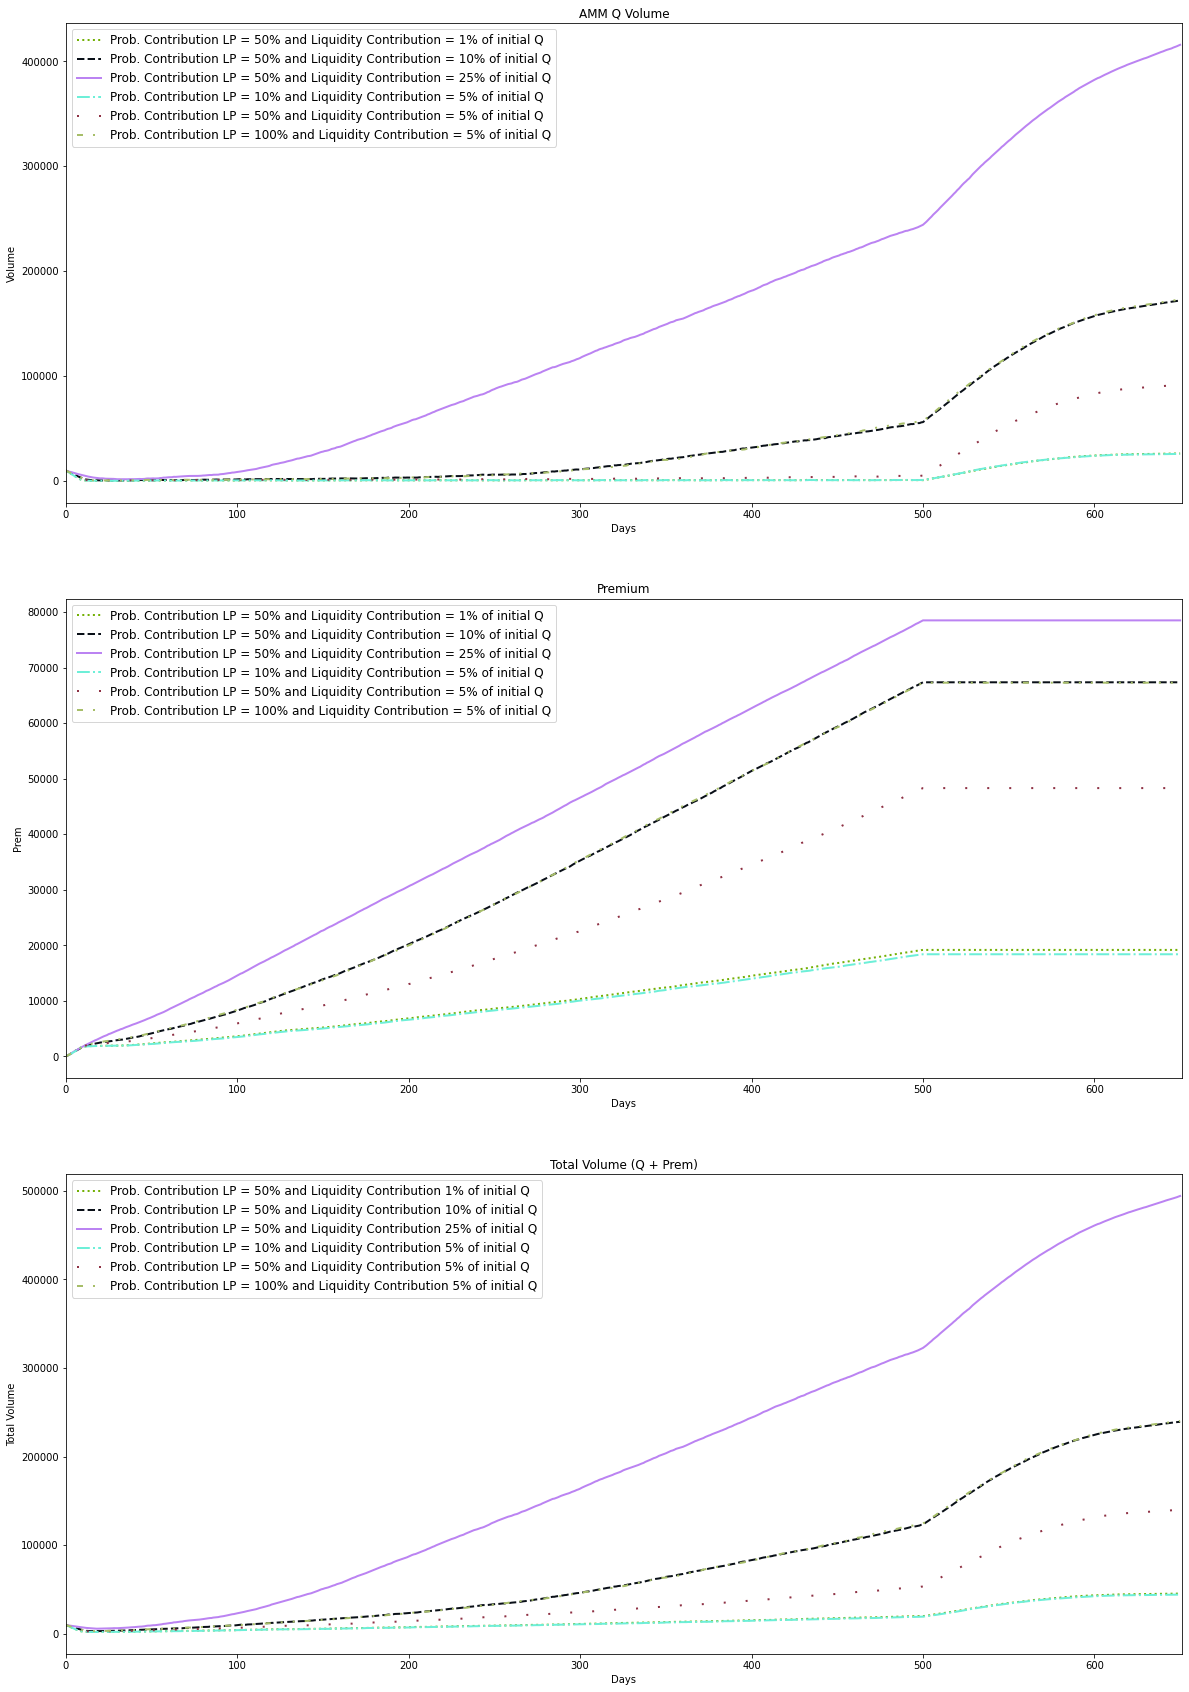

In [4]:
def aux_scenario1(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    plt.title('Total Volume (Q + Prem)')
    plt.xlabel('Days')
    plt.ylabel('Total Volume') 
    plt.xlim([0, len(y)])
    
    for i in list_values:
        scenario_1(i[0], i[1])
        result()
        
        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()

            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
        
        curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0, (3,5,1,5,1,5))]

        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]        
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Prob. Contribution LP = {int(i[0]*100)}% and Liquidity Contribution = {int(i[1]*100)}% of initial Q")
        ax.legend(loc="upper left", prop = {'size': 12})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Prob. Contribution LP = {int(i[0]*100)}% and Liquidity Contribution = {int(i[1]*100)}% of initial Q")
        ax2.legend(loc="upper left", prop = {'size': 12})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Prob. Contribution LP = {int(i[0]*100)}% and Liquidity Contribution {int(i[1]*100)}% of initial Q")
        ax3.legend(loc="upper left", prop = {'size': 12})
        ax3.grid()

    plt.show()

values_scenario1 = [(0.5, 0.01), (0.5, 0.1), (0.5, 0.25), (0.1, 0.05), (0.5, 0.05), (1.0, 0.05)]
aux_scenario1(values_scenario1)

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 108.71 out of 500 invoices in 650 days (21.74 %) |
| Average of paid invoices (capital returned)        | 106.74 out of 108.71 collateralized invoices     |
| Average of unpaid invoices (capital not returned)  | 1.97 out of 108.71 collateralized invoices       |
| Average loss due to unpaid invoices         

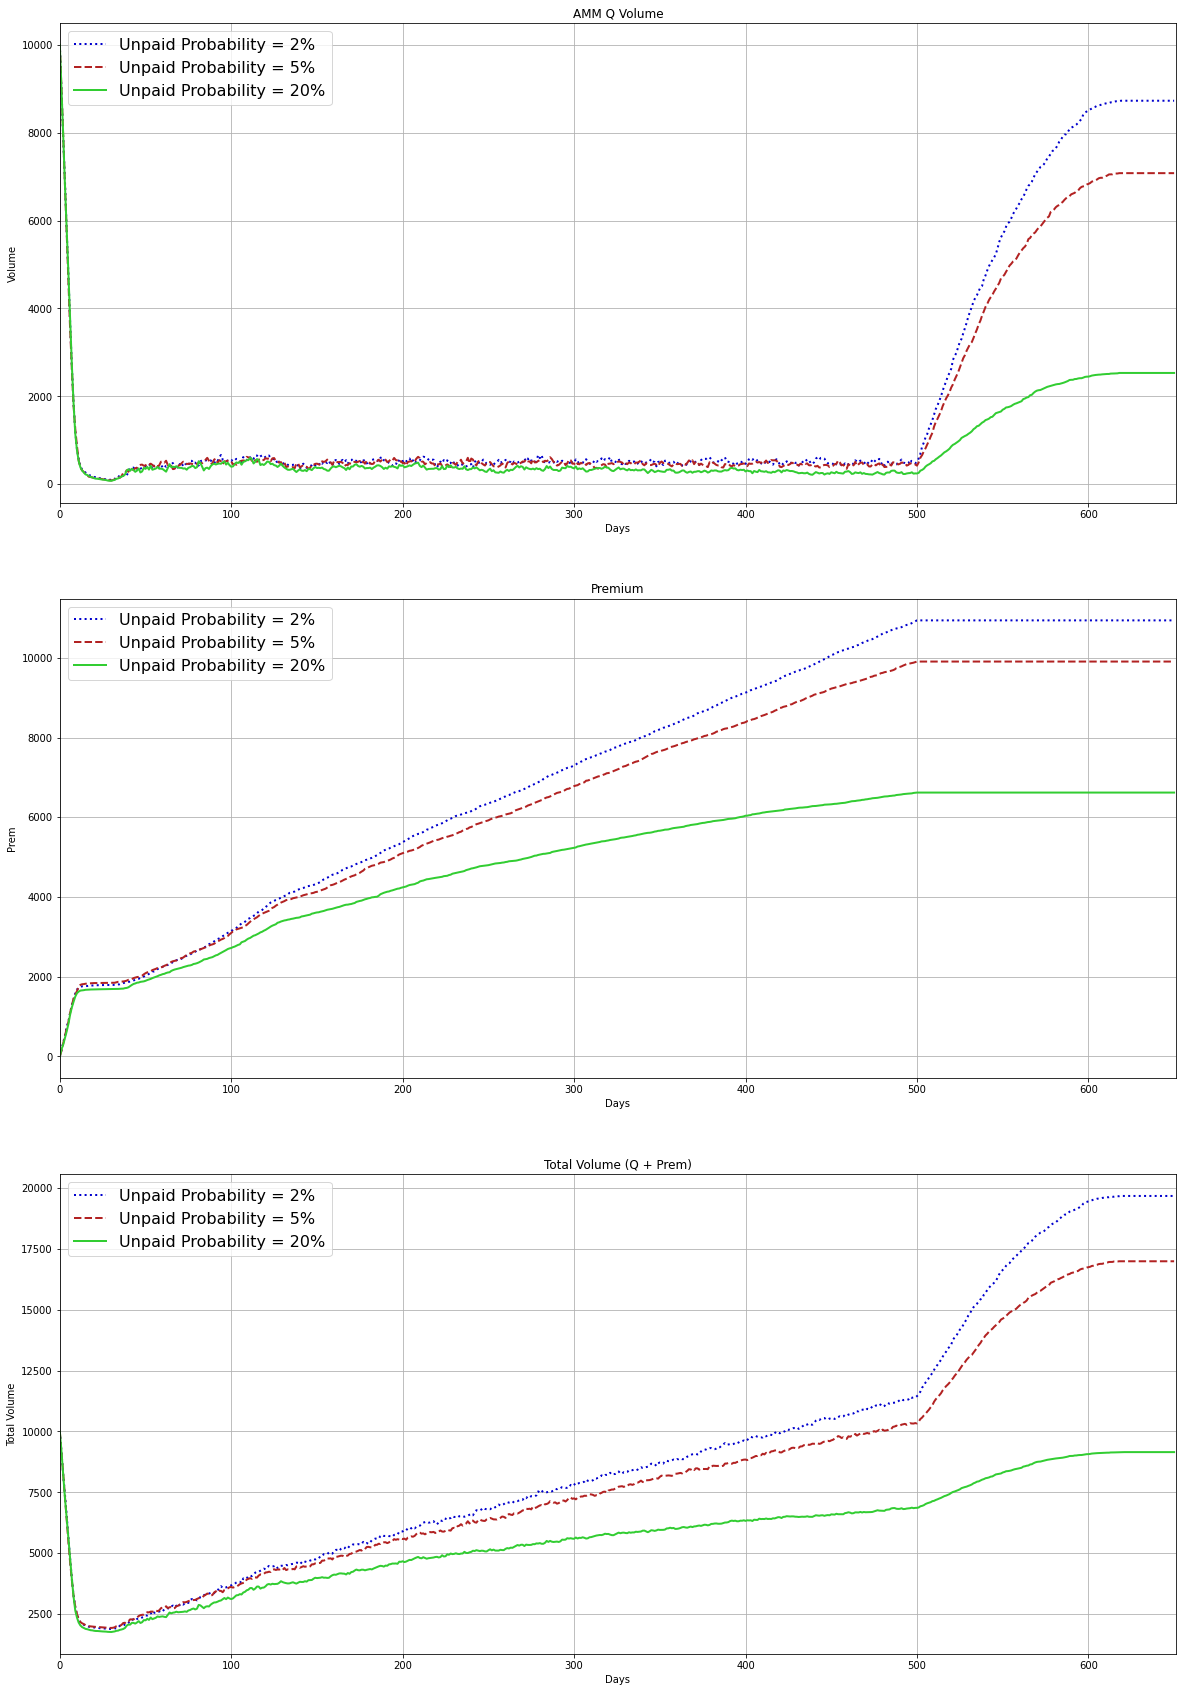

In [5]:
def aux_scenario2(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    for i in list_values:
        scenario_2(i)
        result()

        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()
            
            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
    
        colors = ['mediumblue', 'firebrick', 'limegreen']
        linestyles = ['dotted', 'dashed', 'solid']
        
        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]       
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Unpaid Probability = {int(i*100)}%")
        ax.legend(loc="upper left", prop = {'size': 16})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Unpaid Probability = {int(i*100)}%")
        ax2.legend(loc="upper left", prop = {'size': 16})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)],  label = f"Unpaid Probability = {int(i*100)}%")
        ax3.legend(loc="upper left", prop = {'size': 16})
        ax3.grid()

    plt.show()

values_scenario2 = [0.02, 0.05, 0.2]
aux_scenario2(values_scenario2)

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 158.01 out of 500 invoices in 650 days (31.60 %) |
| Average of paid invoices (capital returned)        | 158.01 out of 158.01 collateralized invoices     |
| Average of unpaid invoices (capital not returned)  | 0.0 out of 158.01 collateralized invoices        |
| Average loss due to unpaid invoices         

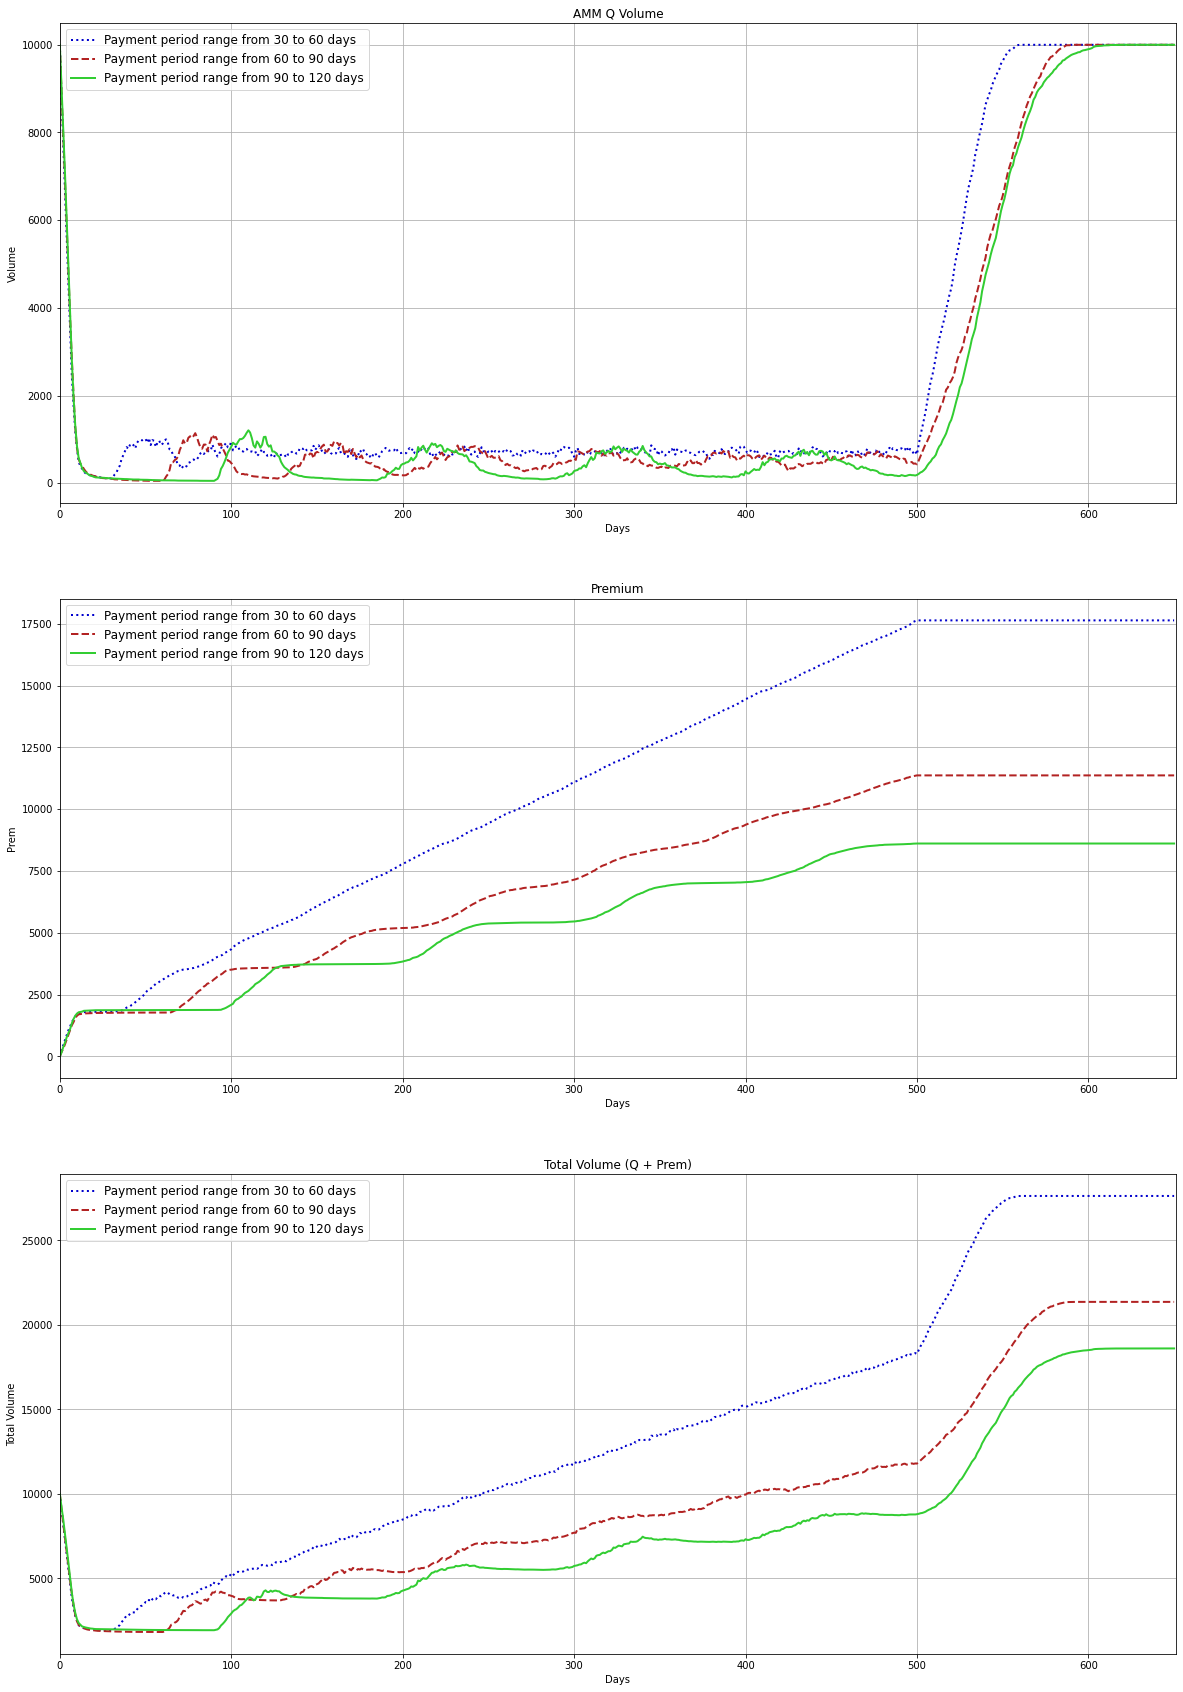

In [6]:
def aux_scenario3(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    plt.title('Total Volume (Q + Prem)')
    plt.xlabel('Days')
    plt.ylabel('Total Volume') 
    plt.xlim([0, len(y)])
    
    for i in list_values:
        scenario_3(i[0], i[1])
        result()
        
        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()

            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
        
        colors = ['mediumblue', 'firebrick', 'limegreen']
        linestyles = ['dotted', 'dashed', 'solid']

        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]        
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Payment period range from {int(i[0])} to {int(i[1])} days")
        ax.legend(loc="upper left", prop = {'size': 12})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Payment period range from {int(i[0])} to {int(i[1])} days")
        ax2.legend(loc="upper left", prop = {'size': 12})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Payment period range from {int(i[0])} to {int(i[1])} days")
        ax3.legend(loc="upper left", prop = {'size': 12})
        ax3.grid()

    plt.show()

values_scenario3 = [(30, 60), (60, 90), (90, 120)]
aux_scenario3(values_scenario3)


---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 500.0 out of 500 invoices in 650 days (100.00 %) |
| Average of paid invoices (capital returned)        | 500.0 out of 500.0 collateralized invoices       |
| Average of unpaid invoices (capital not returned)  | 0.0 out of 500.0 collateralized invoices         |
| Average loss due to unpaid invoices         

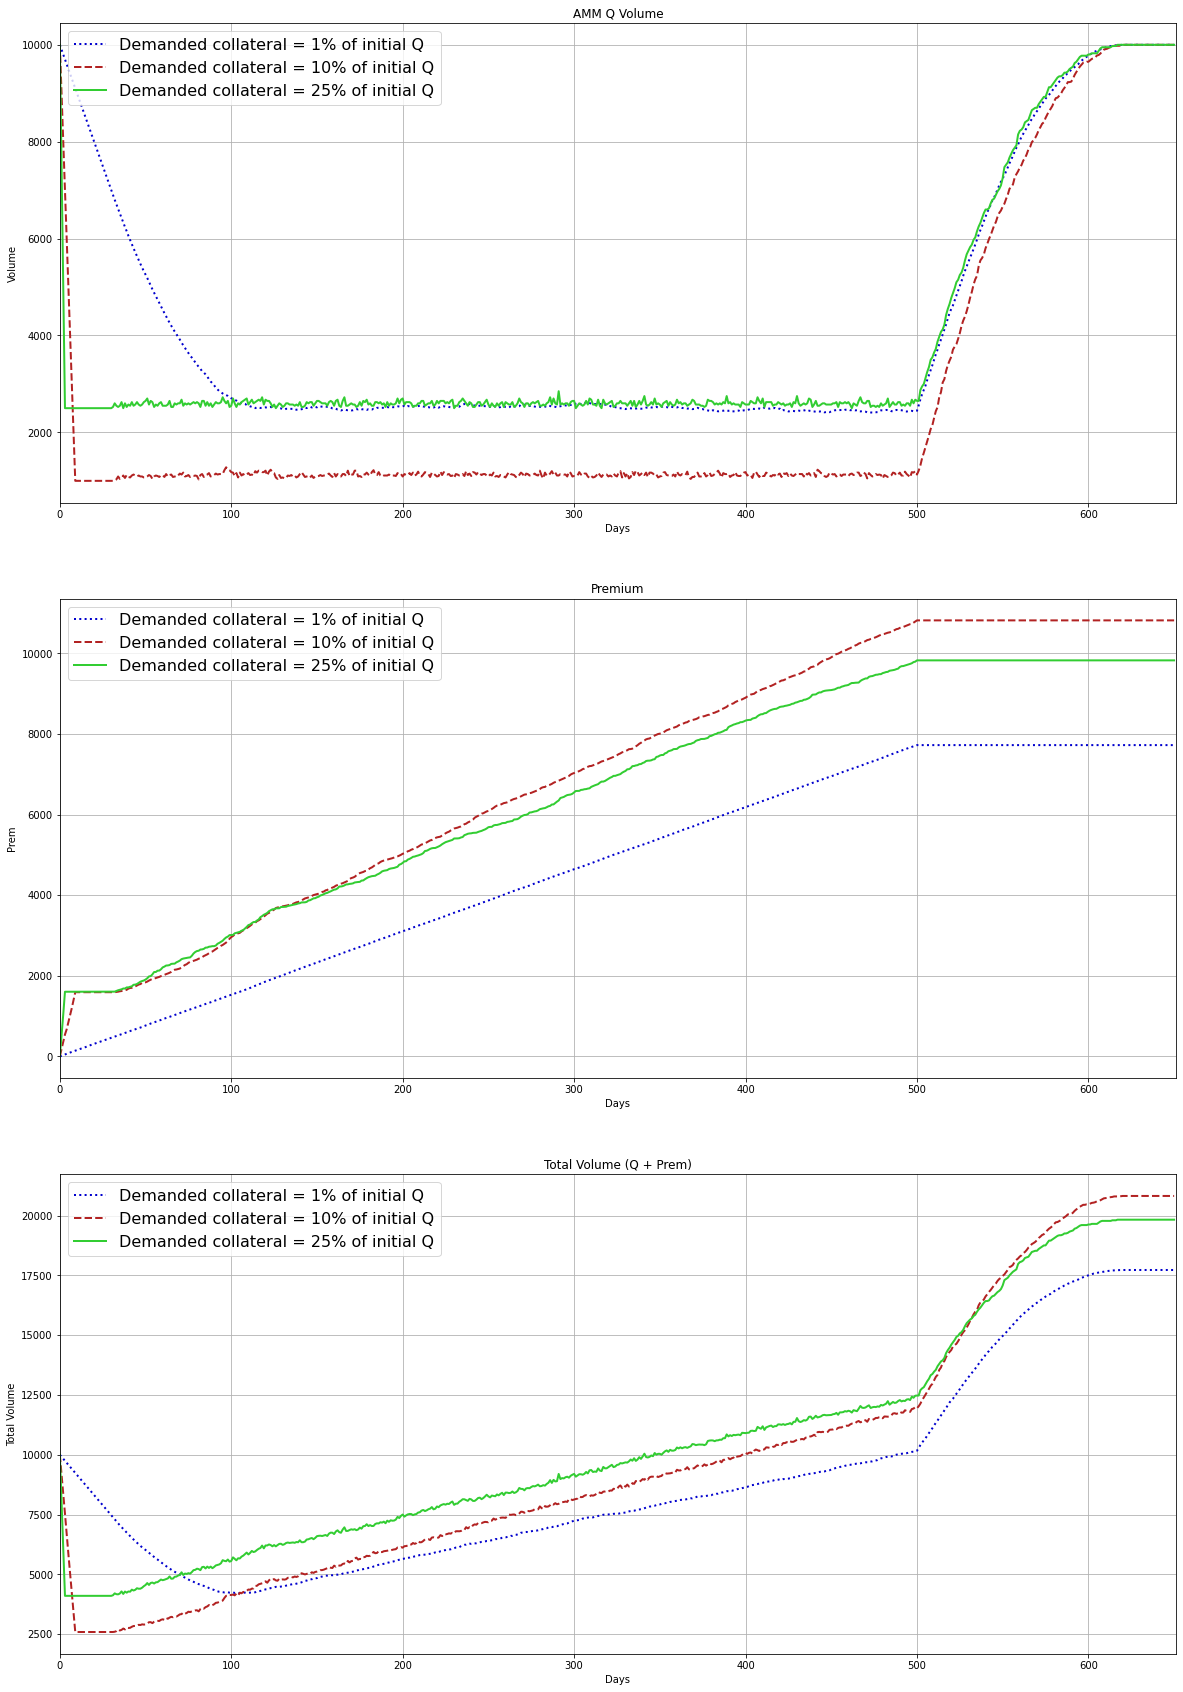

In [7]:
def aux_scenario4(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    for i in list_values:
        scenario_4(i)
        result()

        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()

            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
    
        colors = ['mediumblue', 'firebrick', 'limegreen']
        linestyles = ['dotted', 'dashed', 'solid']
        
        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]       
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Demanded collateral = {int(i*100)}% of initial Q")
        ax.legend(loc="upper left", prop = {'size': 16})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Demanded collateral = {int(i*100)}% of initial Q")
        ax2.legend(loc="upper left", prop = {'size': 16})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)],  label = f"Demanded collateral = {int(i*100)}% of initial Q")
        ax3.legend(loc="upper left", prop = {'size': 16})
        ax3.grid()

    plt.show()

values_scenario4 = [0.01, 0.1, 0.25]
aux_scenario4(values_scenario4)

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 112.78 out of 500 invoices in 650 days (22.56 %) |
| Average of paid invoices (capital returned)        | 112.78 out of 112.78 collateralized invoices     |
| Average of unpaid invoices (capital not returned)  | 0.0 out of 112.78 collateralized invoices        |
| Average loss due to unpaid invoices         

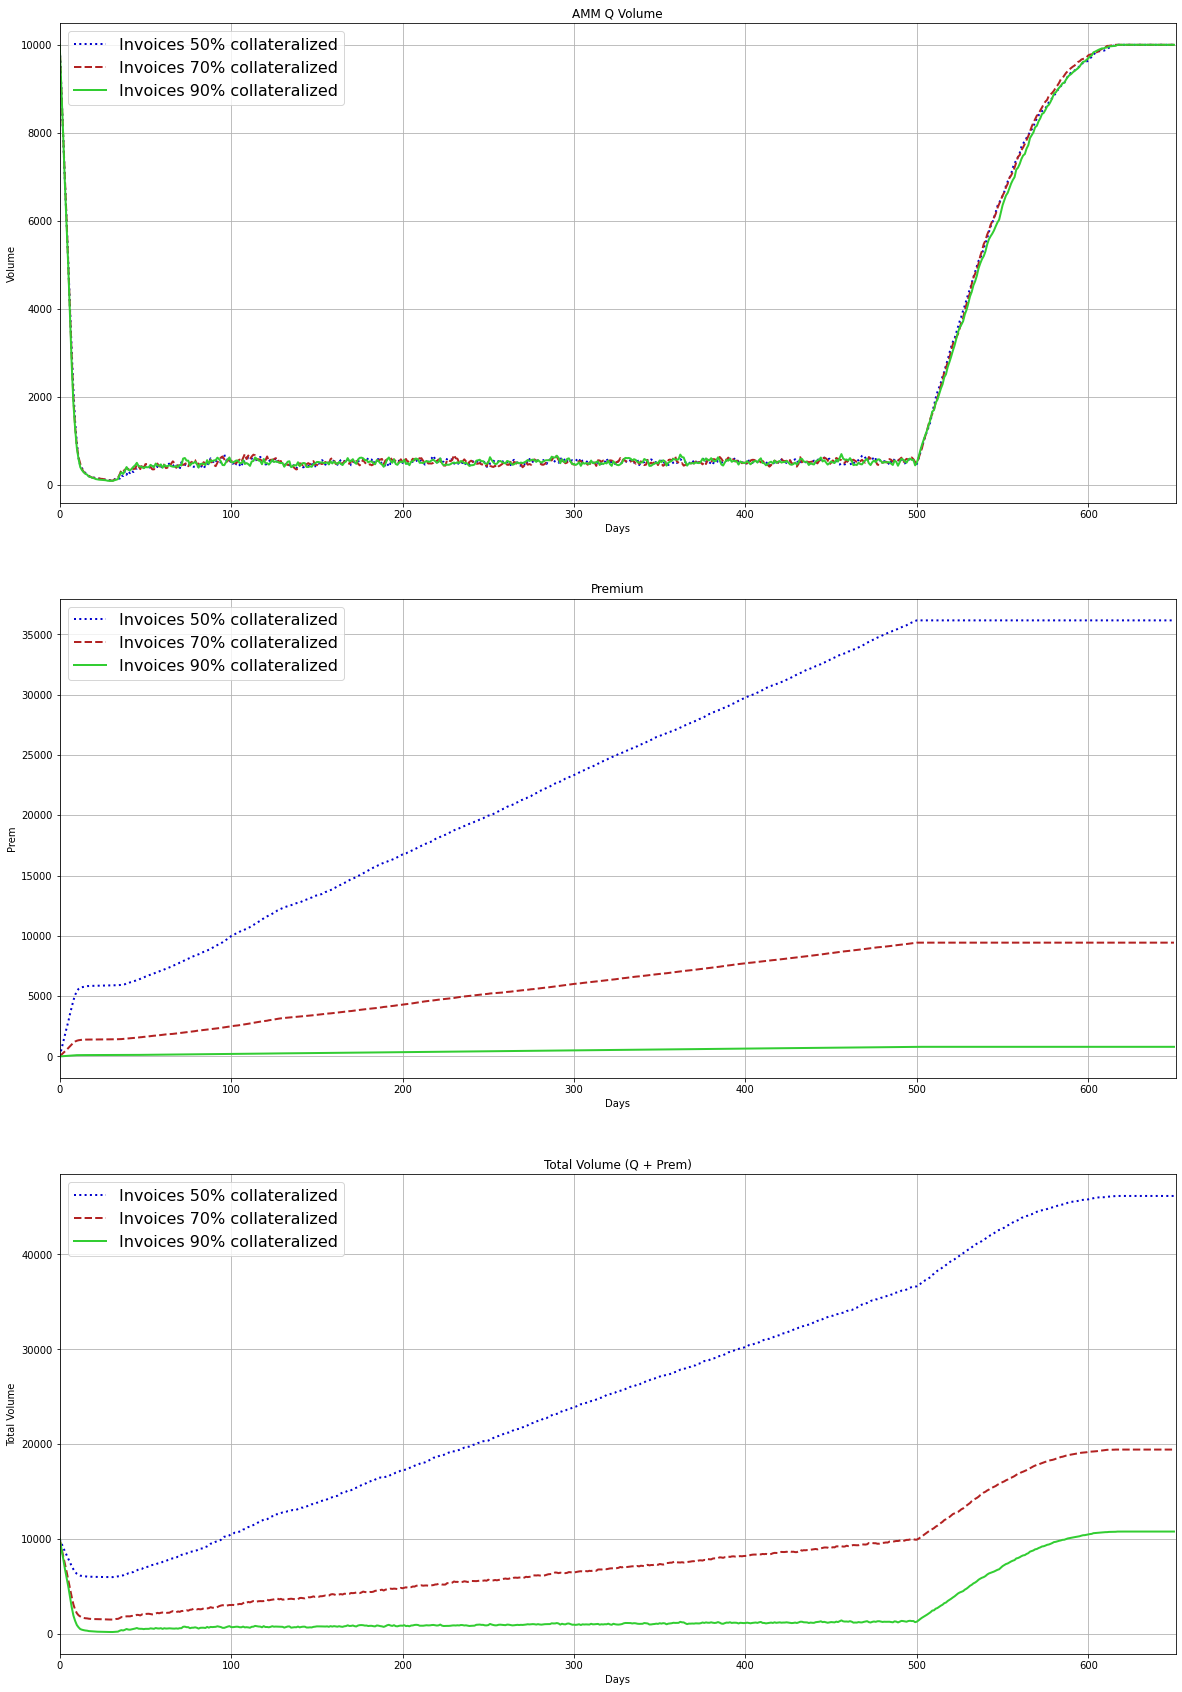

In [8]:
def aux_scenario5(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    for i in list_values:
        scenario_5(i)
        result()

        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()

            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
    
        colors = ['mediumblue', 'firebrick', 'limegreen']
        linestyles = ['dotted', 'dashed', 'solid']
        
        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]       
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Invoices {int(i*100)}% collateralized")
        ax.legend(loc="upper left", prop = {'size': 16})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)], label = f"Invoices {int(i*100)}% collateralized")
        ax2.legend(loc="upper left", prop = {'size': 16})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=colors[list_values.index(i)],  label = f"Invoices {int(i*100)}% collateralized")
        ax3.legend(loc="upper left", prop = {'size': 16})
        ax3.grid()

    plt.show()

values_scenario5 = [0.5, 0.7, 0.9]
aux_scenario5(values_scenario5)

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 91.36 out of 500 invoices in 650 days (18.27 %)  |
| Average of paid invoices (capital returned)        | 82.53 out of 91.36 collateralized invoices       |
| Average of unpaid invoices (capital not returned)  | 8.83 out of 91.36 collateralized invoices        |
| Average loss due to unpaid invoices         

---------------------------------------------------------------------------------------------------------
| Description                                        | Value                                            |
---------------------------------------------------------------------------------------------------------
| Number of simulations                              | 100                                              |
| Simulation time period                             | 650 days                                         |
| Total of invoices                                  | 500                                              |
| Average of accepted invoices (collateralized)      | 33.84 out of 500 invoices in 650 days (6.77 %)   |
| Average of paid invoices (capital returned)        | 17.18 out of 33.84 collateralized invoices       |
| Average of unpaid invoices (capital not returned)  | 16.66 out of 33.84 collateralized invoices       |
| Average loss due to unpaid invoices         

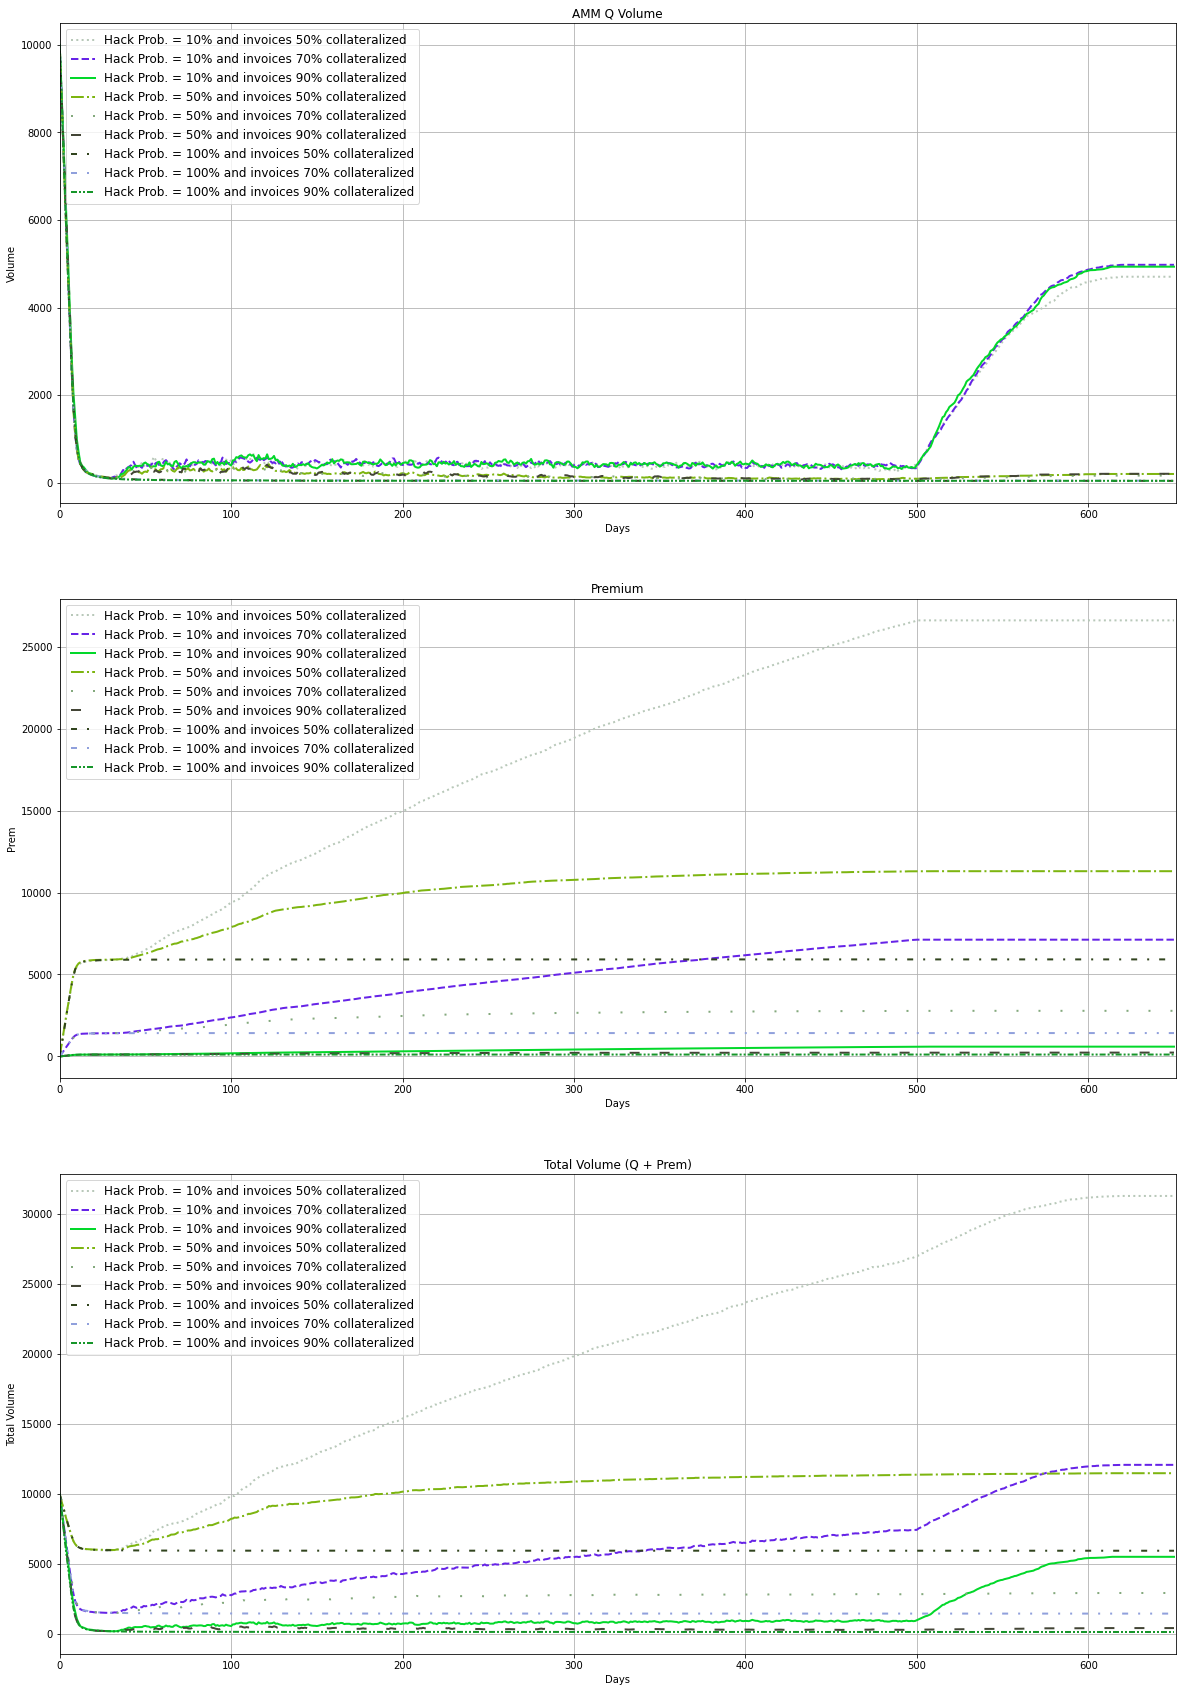

In [9]:
def aux_hack_scenario(list_values):
    reset()
    
    fig = plt.figure(figsize=(20, 30))

    y = np.arange(0, MAX_DAYS_SIM+1, 1, dtype=int)
    plt.rcParams["figure.figsize"] = (20,10)

    ax = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)

    ax.set_title('AMM Q Volume')
    ax.set_xlabel('Days')
    ax.set_ylabel('Volume') 
    ax.set_xlim([0, len(y)])

    ax2.set_title('Premium')
    ax2.set_xlabel('Days')
    ax2.set_ylabel('Prem') 
    ax2.set_xlim([0, len(y)])

    ax3.set_title('Total Volume (Q + Prem)')
    ax3.set_xlabel('Days')
    ax3.set_ylabel('Total Volume') 
    ax3.set_xlim([0, len(y)])

    plt.title('Total Volume (Q + Prem)')
    plt.xlabel('Days')
    plt.ylabel('Total Volume') 
    plt.xlim([0, len(y)])
    
    for i in list_values:
        hack_scenario(i[0], i[1])
        result()
        
        array_q_vol = []
        array_prem = []
        array_vol = []

        for j in range(0, NUM_SIM):    
            results = rkAMM()

            array_q_vol.append(results[8]) 
            array_prem.append(results[9])
            array_vol.append(results[10])
        
        curve_color = (random.uniform(0,1), random.uniform(0,1), random.uniform(0,1))
        linestyles = ['dotted', 'dashed', 'solid', 'dashdot', (0, (1,10)), (0,(5,10)), (0, (3,5,1,5)), (0, (3,5,1,5,1,5)), (0, (3,1,1,1,1,1))]

        array_q_vol = [sum(x) for x in zip(*array_q_vol)]
        q_volume_values = [x / NUM_SIM for x in array_q_vol]        
        ax.plot(y, q_volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Hack Prob. = {int(i[0]*100)}% and invoices {int(i[1]*100)}% collateralized")
        ax.legend(loc="upper left", prop = {'size': 12})
        ax.grid()

        array_prem = [sum(x) for x in zip(*array_prem)]
        prem_values = [x / NUM_SIM for x in array_prem]
        ax2.plot(y, prem_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Hack Prob. = {int(i[0]*100)}% and invoices {int(i[1]*100)}% collateralized")
        ax2.legend(loc="upper left", prop = {'size': 12})
        ax2.grid()

        array_vol = [sum(x) for x in zip(*array_vol)]
        volume_values = [x / NUM_SIM for x in array_vol]
        ax3.plot(y, volume_values, linewidth=2, linestyle=linestyles[list_values.index(i)], color=curve_color, label = f"Hack Prob. = {int(i[0]*100)}% and invoices {int(i[1]*100)}% collateralized")
        ax3.legend(loc="upper left", prop = {'size': 12})
        ax3.grid()

    plt.show()

values_hack_scenario = [(0.1, 0.5), (0.1, 0.7), (0.1, 0.9), (0.5, 0.5), (0.5, 0.7), (0.5, 0.9), (1.0, 0.5), (1.0, 0.7), (1.0, 0.9)]
aux_hack_scenario(values_hack_scenario)
